In [4]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab
!pip install pandas==1.5.3 numpy==1.23.5 --force-reinstall

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
dask-expr 1.1.21 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
xarray 2025.1.2 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.3 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4

In [1]:
import pandas as pd
print(pd.__version__)

1.5.3


# Antimicrobial Peptide Design

>Using MRL to design antimicrobial peptides

## Antimicrobial Peptide Design

This tutorial runs an end to end workflow for designing antimicrobial peptides using MRL.

Antimicrobial peptides are a family of peptides that kill bacteria. These peptides are of interest for antibiotics and anticancer therapeutics

## Performance Notes

The workflow in this notebook is more CPU-constrained than GPU-constrained due to the need to evaluate samples on CPU. If you have a multi-core machine, it is recommended that you uncomment and run the `set_global_pool` cells in the notebook. This will trigger the use of multiprocessing, which will result in 2-4x speedups.

This notebook may run slow on Collab due to CPU limitations.

If running on Collab, remember to change the runtime to GPU

In [2]:
! pip install -Uqq mrl-pypi

In [3]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [4]:
os.makedirs('untracked_files', exist_ok=True)

## Data

The dataset comes from the [AMPlify](https://github.com/bcgsc/AMPlify) repo. It contains ~8300 short peptides classified as antimicrobial or not antimicrobial

In [5]:
# if in the repo
# df = pd.read_csv('../files/anti_microbial_peptides.csv')

# if in Collab
download_files()
df = pd.read_csv('files/anti_microbial_peptides.csv')

In [6]:
df.head()

,name,sequence,dataset,label
0,>trAMP0001,GLLDTFKNLALNAAKSAGVSVLNSLSCKLSKTC,train,1
1,>trAMP0002,AKKPVAKKAAGGVKKPK,train,1
2,>trAMP0003,GIIDIAKKLVGGIRNVLGI,train,1
3,>trAMP0004,MAGFLKVVQLLAKYGSKAVQWAWANKGKILDWLNAGQAIDWVVSKI...,train,1
4,>trAMP0005,YGPGDGHGGGHGGGHGGGHGNGQGGGHGHGPGGGFGGGHGGGHGGG...,train,1


Most peptides are short, less than 50 amino acids

<Axes: >

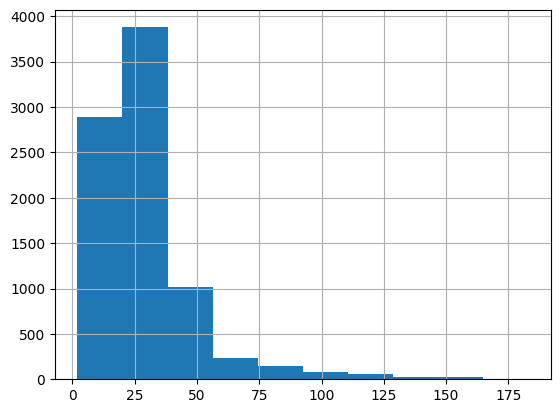

In [7]:
df.sequence.map(lambda x: len(x)).hist()

## Score Function

Now we want to develop a score function for predicting antimicrobial activity. We will use a CNN encoder with a MLP head to predict a binary classification value for antimicrobial activity.

Our input data will be token integers for amino acids. Note that fingerprint representations are a poor fit for peptide work because peptides contain many repeating substructures.

We will train on 95% of the data and validate on the 5% held out.

In [8]:
train_df = df[df.dataset=='train']
valid_df = df[df.dataset=='valid']

In [9]:
aa_vocab = CharacterVocab(AMINO_ACID_VOCAB)

amp_ds = Text_Prediction_Dataset(train_df.sequence.values, train_df.label.values, aa_vocab)
test_ds = Text_Prediction_Dataset(valid_df.sequence.values, valid_df.label.values, aa_vocab)

This is the model we will use:

In [10]:
class Predictive_CNN(nn.Module):
    def __init__(self,
                 d_vocab,
                 d_embedding,
                 d_latent,
                 filters,
                 kernel_sizes,
                 strides,
                 dropouts,
                 mlp_dims,
                 mlp_drops,
                 d_out
                ):
        super().__init__()

        self.conv_encoder = Conv_Encoder(
                                        d_vocab,
                                        d_embedding,
                                        d_latent,
                                        filters,
                                        kernel_sizes,
                                        strides,
                                        dropouts,
                                    )

        self.mlp_head = MLP(
                            d_latent,
                            mlp_dims,
                            d_out,
                            mlp_drops
                            )

    def forward(self, x):
        encoded = self.conv_encoder(x)
        out = self.mlp_head(encoded)
        return out

In [11]:
d_vocab = len(aa_vocab.itos)
d_embedding = 256
d_latent = 512
filters = [256, 512, 1024]
kernel_sizes = [7, 7, 7]
strides = [2,2,2]
dropouts = [0.2, 0.2, 0.2]
mlp_dims = [512, 256, 128]
mlp_drops = [0.2, 0.2, 0.2]
d_out = 1


amp_model = Predictive_CNN(
                    d_vocab,
                    d_embedding,
                    d_latent,
                    filters,
                    kernel_sizes,
                    strides,
                    dropouts,
                    mlp_dims,
                    mlp_drops,
                    d_out
                )

In [12]:
r_agent = PredictiveAgent(amp_model, BinaryCrossEntropy(), amp_ds, opt_kwargs={'lr':1e-3})

In [13]:
r_agent.train_supervised(32, 12, 1e-3)

Epoch,Train Loss,Valid Loss,Time
0,0.42555,0.38622,00:25
1,0.37093,0.53180,00:03
2,0.35350,0.46209,00:03
3,0.31133,0.38473,00:03
4,0.29083,0.38062,00:03
5,0.25461,0.35672,00:03
6,0.24050,0.34401,00:03
7,0.19581,0.38019,00:03
8,0.16828,0.38067,00:03
9,0.16694,0.38676,00:03


Optional: save score function weights

In [14]:
r_agent.save_weights('untracked_files/amp_predictor.pt')

Optional: to load the exact weights used, run the following:

In [15]:
r_agent.load_state_dict(model_from_url('amp_predictor.pt'))

In [16]:
# validate

valid_dl = test_ds.dataloader(256, shuffle=False)
r_agent.model.eval();

preds = []
targs = []

with torch.no_grad():
    for i, batch in enumerate(valid_dl):
        batch = to_device(batch)
        x,y = batch
        pred = r_agent.model(x)
        preds.append(pred.detach().cpu())
        targs.append(y.detach().cpu())

preds = torch.cat(preds).numpy()
targs = torch.cat(targs).numpy()

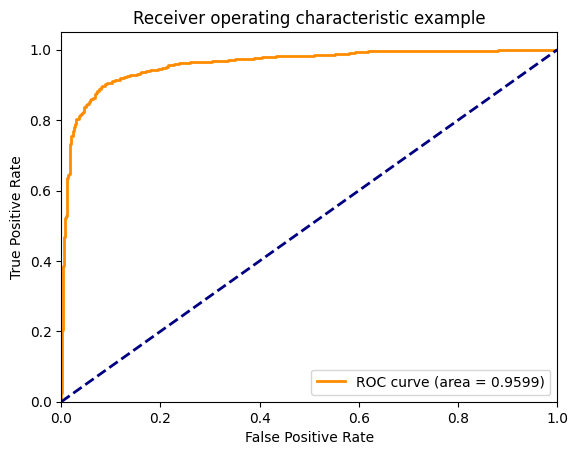

In [17]:
fpr, tpr, _ = roc_curve(targs, torch.tensor(preds).sigmoid().squeeze().numpy())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Chemical Space

Next we need to develop our chemical space. This is where we decide what sequences will be allowed and what sequences will be removed.

Getting the right filtering parameters makes a huge difference in sequence quality. In practice, finding the right constraints is an interative process. First run a generative screen. Then examine the highest scoring sequences and look for undesirable properties or structural features. Then update the template and iterate.

For peptides, the presence of Arginine has shown to be toxic [[ref](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5625148/)]. We will apply a template filter for the number of Arginine residues per unit length.

We will also limit the maximum residue frequency in a sample to 0.4. This prevents a common failure mode of seeing the same residue repeated multiple times (ie `MSSSSSSSRP`). This is a flaw in the simplistic score functions we are using

In [18]:
aa_vocab = CharacterVocab(AMINO_ACID_VOCAB)

template = Template([ValidityFilter(),
                     CharacterCountFilter(['A'], min_val=0, max_val=0.1, per_length=True, mode='protein'),
                     CharacterCountFilter(aa_vocab.itos[4:], min_val=0, max_val=0.3,
                                          per_length=True, mode='protein')],
                    [], fail_score=-10., log=False, use_lookup=False, mode='protein')

template_cb = TemplateCallback(template, prefilter=True)

## Load Model

We load the `LSTM_LM_Small_Swissprot` model. This is a basic LSTM-based language model trained on part of the Swissprot protein database

In [19]:
agent = LSTM_LM_Small_Swissprot(drop_scale=0.3, opt_kwargs={'lr':1e-4})

## Fine-Tune Model

The pretrained model we loaded is a very general model that can produce a high diversity of structures. However, what we actually want are structues with antimicrobial activity. To induce this, we fine-tune on the active peptides in the dataset

In [20]:
agent.update_dataset_from_inputs(df[df.label==1].sequence.values)
agent.train_supervised(32, 8, 5e-5)
agent.base_to_model()

Epoch,Train Loss,Valid Loss,Time
0,1.01853,1.15365,00:14
1,0.97591,1.05611,00:14
2,0.89067,0.99407,00:14
3,0.86073,0.97877,00:14
4,0.89046,0.96882,00:13
5,0.89428,0.96397,00:13
6,0.86934,0.96178,00:13
7,0.87772,0.96150,00:13


Optional: save fine-tuned weights

In [21]:
agent.save_weights('untracked_files/finetuned_model.pt')

In [22]:
agent.load_weights('untracked_files/finetuned_model.pt')

# Reinforcement Learning

Now we enter the reinforcement learning stage

### Loss

We use `PPO` as our policy gradient loss

In [23]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)

loss = PolicyLoss(pg, 'PPO',
                   value_head=ValueHead(256),
                   v_update_iter=2,
                   vopt_kwargs={'lr':1e-3})

### Reward

Here we pass the reward agent we trained earlier to a callback.

Since our model is a classification model, we have a decision with respect to what value we output from our score function. We could output the raw logit value from the model, or the sigmoid-scaled classification prediction.

If we use the sigmoid-scaled output, we tend to get lots of samples with scores in the `0.999` range that only differ by a very small amount. This can make it difficult to differentiate the true winners.

If we use the logit output, we can get much better differentiation of samples at the top end. However, we have a much higher chance of finding weird samples that get absurd logit values.

The code below uses the raw logit value, clipped to a range of `[-10, 10]`

In [24]:
d_vocab = len(aa_vocab.itos)
d_embedding = 256
d_latent = 512
filters = [256, 512, 1024]
kernel_sizes = [7, 7, 7]
strides = [2,2,2]
dropouts = [0.2, 0.2, 0.2]
mlp_dims = [512, 256, 128]
mlp_drops = [0.2, 0.2, 0.2]
d_out = 1


reward_model = Predictive_CNN(
                    d_vocab,
                    d_embedding,
                    d_latent,
                    filters,
                    kernel_sizes,
                    strides,
                    dropouts,
                    mlp_dims,
                    mlp_drops,
                    d_out
                )


r_ds = Text_Prediction_Dataset(['M'], [0.], aa_vocab)

r_agent = PredictiveAgent(reward_model, BinaryCrossEntropy(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('untracked_files/amp_predictor.pt')
# r_agent.load_state_dict(model_from_url('amp_predictor.pt')) # optional - load exact weights

reward_model.eval();

freeze(reward_model)

class ClippedModelReward():
    def __init__(self, agent, minclip, maxclip):
        self.agent = agent
        self.minclip = minclip
        self.maxclip = maxclip

    def __call__(self, sequences):
        preds = self.agent.predict_data(sequences)
        preds = torch.clamp(preds, self.minclip, self.maxclip)
        return preds

reward_function = Reward(ClippedModelReward(r_agent, -10, 10), weight=1)

amp_reward = RewardCallback(reward_function, 'amp')

### Optional Reward: Stability Metric

There has been a lot of great work recently looking at large scale transformer language models for unsupervised learning of protein structures. One interesting thing that has emerged is a rough relationship between the protein sequence log probability given by a generative model and the stability of the protein sequence.

We can use the log probability values from a pretrained protein transformer model as a proxy for stability. Including this as a reward function can help keep the generated peptides realistic.

To include this as a reward term, run the code below to install the [ESM](https://github.com/facebookresearch/esm) library to access a pretrained protein transformer model.

In the interest of time, we will use the smallest ESM model with 43M parameters, rather than the large scale 630M parameter model. Note that even with the smaller model, this reward term adds significanly to the training runtime

In [25]:
# Optional: insall ESM
! pip install fair-esm

In [26]:
import esm

In [27]:
protein_model, alphabet = esm.pretrained.esm1_t6_43M_UR50S()
batch_converter = alphabet.get_batch_converter()

In [28]:
class PeptideStability():
    def __init__(self, model, alphabet, batch_converter):
        self.model = model
        to_device(self.model)
        self.alphabet = alphabet
        self.batch_converter = batch_converter

    def __call__(self, samples):

        data = [
            (f'protein{i}', samples[i]) for i in range(len(samples))
        ]

        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)

        with torch.no_grad():
            results = self.model(to_device(batch_tokens))

        lps = F.log_softmax(results['logits'], -1)

        mean_lps = lps.gather(2, to_device(batch_tokens).unsqueeze(-1)).squeeze(-1).mean(-1)

        return mean_lps

In [29]:
ps = PeptideStability(protein_model, alphabet, batch_converter)

In [30]:
stability_reward = Reward(ps, weight=0.1, bs=300)
stability_cb = RewardCallback(stability_reward, name='stability')

In [31]:
stability_reward(df.sequence.values[:10])

tensor([-2.6915, -3.0885, -3.0648, -1.6828, -0.1794, -3.9859, -3.7000, -3.5714,
        -2.2517, -3.6625], device='cuda:0')

### Samplers

We create the following samplers:
- `sampler1 ModelSampler`: this samples from the main model. This sample will add 1000 compounds to the buffer each buffer build, and sample 40% of each batch on the fly from the main model.
- `sampler2 ModelSampler`: this samples from the baseline model and is not sampled live on each batch
- `sampler3 LogSampler`: this samples high scoring samples from the lig
- `sampler4 TokenSwapSampler`: this uses token swap comibichem to generate new samples from high scoring samples
- `sampler5 DatasetSampler`: this sprinkles in a small amount of known actives into each buffer build. Note that we subset by peptide length to align with the generated length (75 amino acids)

In [32]:
gen_bs = 1500

sampler1 = ModelSampler(agent.vocab, agent.model, 'live', 1000, 0., gen_bs)
sampler2 = ModelSampler(agent.vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 98, 200)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 98, 200, aa_vocab, 0.2)
sampler5 = DatasetSampler(df[(df.label==1) & (df.sequence.map(lambda x: len(x)<=75))].sequence.values,
                          'data', buffer_size=4)

samplers = [sampler1, sampler2, sampler3, sampler4, sampler5]

### Callbacks

Additional callbacks
- `SupervisedCB`: runs supervised training on the top 3% of samples every 400 batches
- `MaxCallback`: prints the max reward for each batch
- `PercentileCallback`: prints the 90th percentile score each batch

In [33]:
supervised_cb = SupervisedCB(agent, 20, 0.5, 98, 1e-4, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

## Environment and Train

Now we can put together our Environment and run the training process

In [34]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[amp_reward, stability_cb], losses=[loss],
                 cbs=cbs)

In [35]:
set_global_pool(min(12, os.cpu_count()))

In [37]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [38]:
env.fit(128, 75, 300, 20)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,amp,stability,PPO,rewards_live_p90,rewards_live_max
20,1.080,1.080,0.969,1.000,128,0.000,1.000,3.701,-2.621,3.385,5.957,7.983
40,2.532,2.532,0.906,1.000,128,0.000,1.000,4.471,-1.939,4.485,7.644,8.748
60,5.077,5.077,0.875,1.000,128,0.000,1.000,6.113,-1.036,5.696,8.669,9.057
80,6.241,6.241,0.875,1.000,128,0.000,1.000,6.964,-0.723,4.218,9.117,9.704
100,6.885,6.885,0.844,1.000,128,0.000,1.000,7.363,-0.477,985.126,8.657,9.776
120,7.747,7.747,0.844,1.000,128,0.000,1.000,8.232,-0.484,1.748,9.679,9.705
140,8.183,8.183,0.773,1.000,128,0.000,1.000,8.583,-0.399,1.216,9.173,9.772
160,8.327,8.327,0.766,1.000,128,0.000,1.000,8.787,-0.460,0.909,9.677,9.713
180,8.059,8.059,0.875,1.000,128,0.000,1.000,8.474,-0.415,0.969,9.702,9.749
200,8.699,8.699,0.828,1.000,128,0.000,1.000,9.054,-0.354,0.670,9.734,9.772


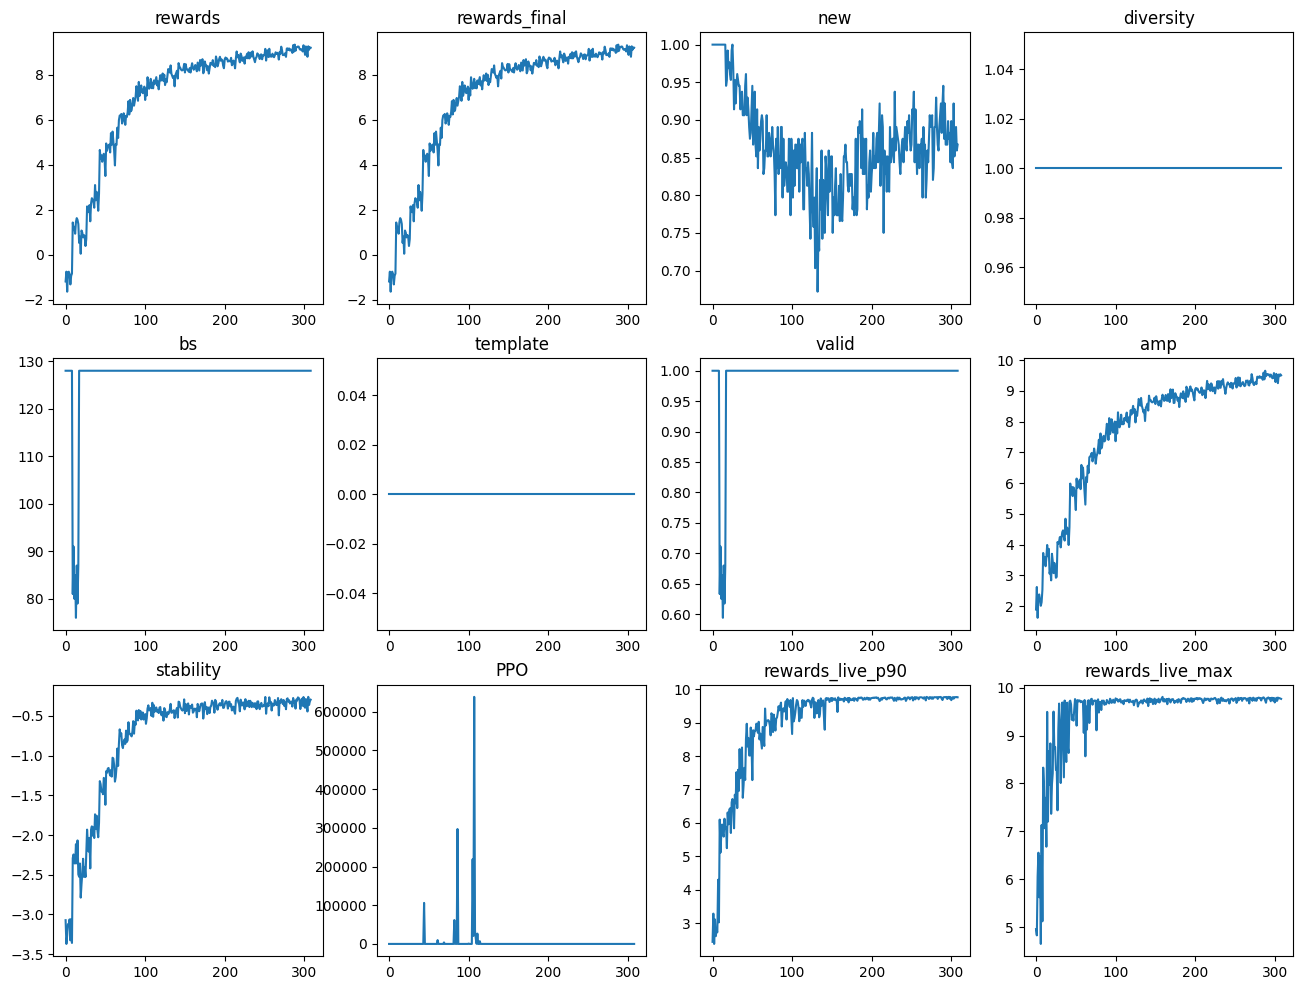

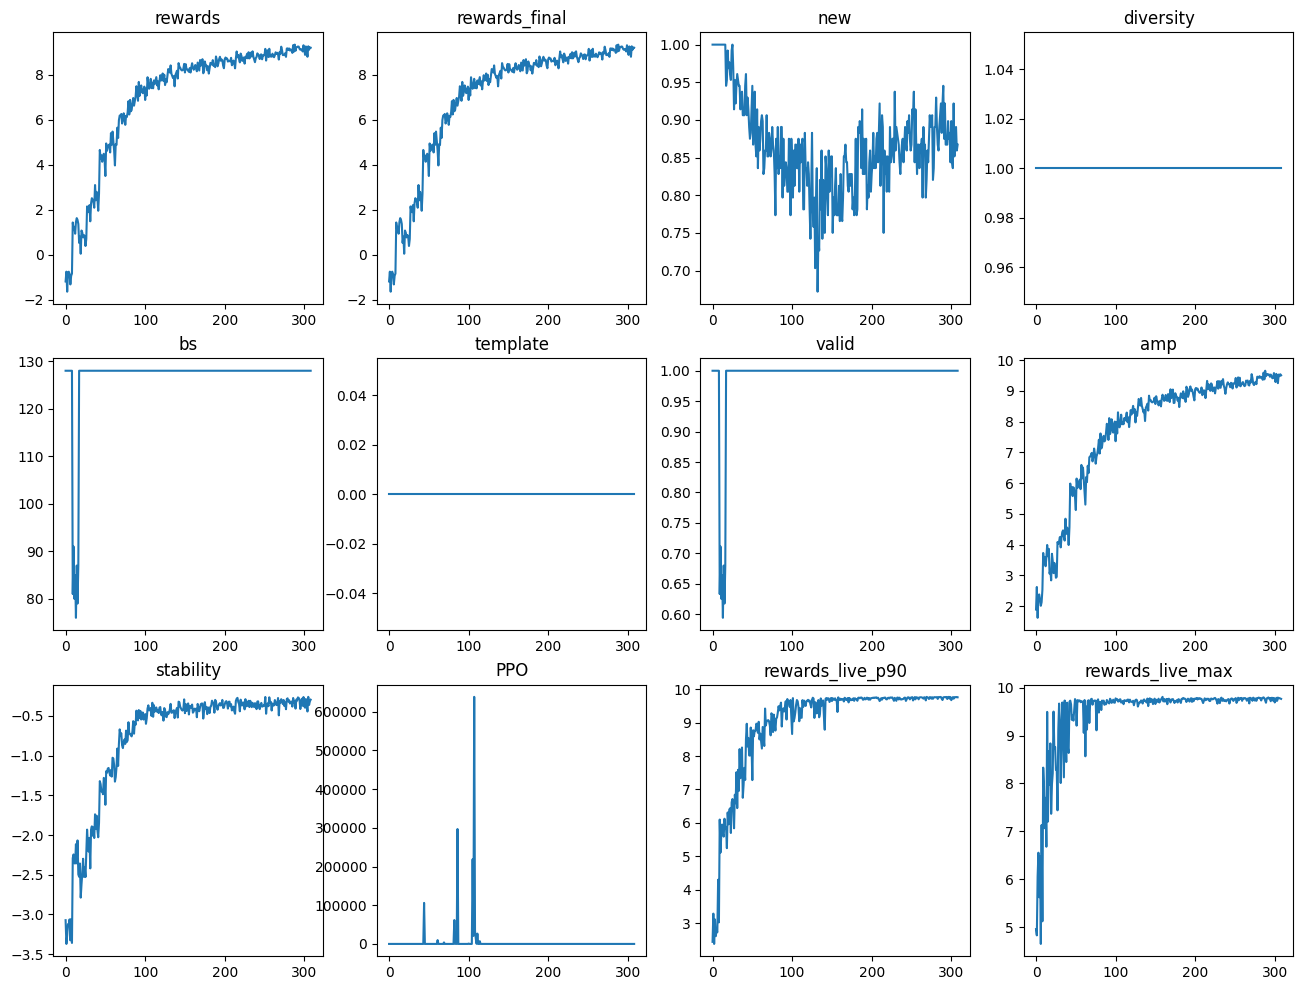

In [39]:
env.log.plot_metrics()

## Evaluation

Looking at high scoring sequences, we see many sequences contain with a high concentration of `K` residues. These features likely come from a small number of dataset samples with high `K` contents. For example, `AATKPKKAGAEAAPKKPAKKQTKKKPAKKAGGKKKPKRAGAKKAKK` is a AMP sequence in the dataset.

If these traits are undesirable, they can be controlled by updating the `Template` to limit other residues the same way we limited `A` residues.

In [40]:
env.log.df[env.log.df.rewards>9.8]

,samples,sources,rewards,rewards_final,template,amp,stability,PPO
17405,GLLTGLAKVLKKMGKKCGIICTALKGVKCGTGYVIGCGIGKILKAG...,live_buffer,9.80782,9.80782,0.0,10.0,-0.192179,0.312495


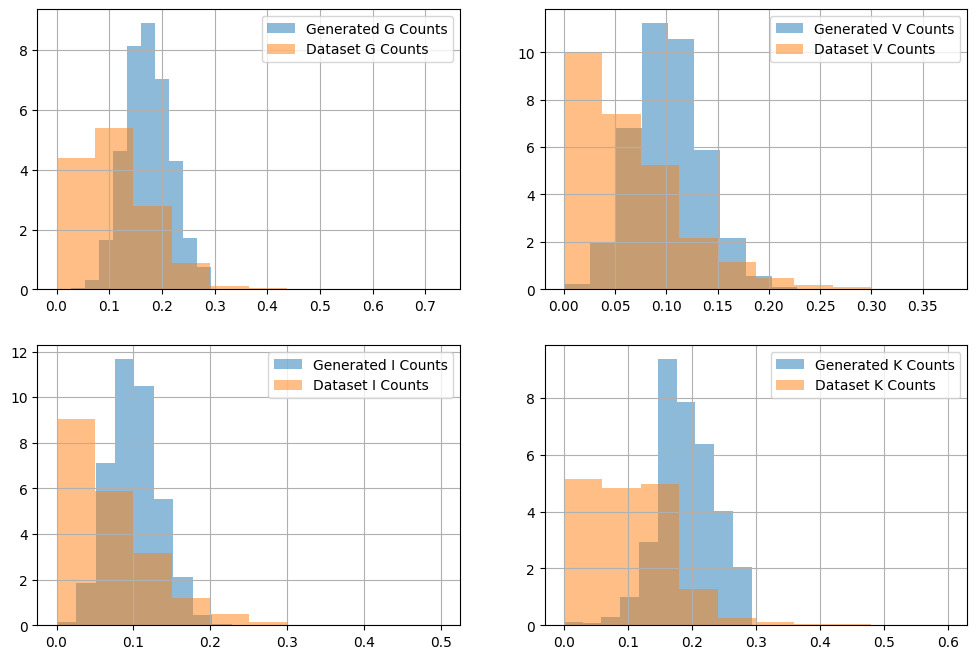

In [41]:
aas = ['G', 'V', 'I', 'K']

fig, axes = plt.subplots(2,2, figsize=(12,8))

for i, ax in enumerate(axes.flat):
    if i<len(aas):
        env.log.df[env.log.df.rewards>9.].samples.map(
            lambda x: x.count(aas[i])/len(x)).hist(density=True, alpha=0.5, label=f'Generated {aas[i]} Counts',
                                                  ax=ax)
        df[df.label==1].sequence.map(
            lambda x: x.count(aas[i])/len(x)).hist(density=True, alpha=0.5, label=f'Dataset {aas[i]} Counts',
                                                  ax=ax)
        ax.legend()
    else:
        ax.axis('off')